In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
# Use the exact path you provided for your JSON file
file_path = r"D:\Projects\aave-wallet-scoring\user-wallet-transactions.json"

# --- Load Data ---
print("Loading data...")
try:
    # The raw data is a list of json objects, so we need to read it line by line
    df = pd.read_json(file_path, lines=True)
    print("Data loaded successfully with lines=True!")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
    exit()
except ValueError:
    # Fallback for if the json is not line-delimited
    print("ValueError reading JSON. Trying standard read_json...")
    df = pd.read_json(file_path)
    print("Data loaded successfully with standard reader!")


# --- Preprocessing and Data Cleaning ---

# Define token decimals for accurate value calculation. This is standard practice in DeFi.
TOKEN_DECIMALS = {
    'USDC': 6,
    'USDT': 6,
    'DAI': 18,
    'WETH': 18,
    'WMATIC': 18,
    'WBTC': 8,
    'AAVE': 18,
    'EURS': 2
    # Default to 18 if a token is not in this list
}

def calculate_real_amount_usd(row):
    """
    Calculates the true USD value from the transaction data.
    DeFi protocols store amounts as large integers, which need to be adjusted by decimals.
    """
    action_data = row['actionData']
    
    if not isinstance(action_data, dict):
        return 0.0

    # Extract the raw components from the dictionary
    amount_str = action_data.get('amount')
    price_usd_str = action_data.get('assetPriceUSD')
    symbol = action_data.get('assetSymbol')

    # If any essential value is missing, we cannot calculate the amount.
    if not all([amount_str, price_usd_str, symbol]):
        return 0.0

    try:
        # Convert string values to numbers for calculation
        amount = float(amount_str)
        price_usd = float(price_usd_str)
        
        # Get the correct number of decimals for the asset, defaulting to 18
        decimals = TOKEN_DECIMALS.get(symbol, 18)

        # The core calculation: (amount / 10^decimals) * price_in_usd
        final_usd_amount = (amount / (10**decimals)) * price_usd
        return final_usd_amount

    except (ValueError, TypeError):
        # If any value can't be converted to a number, return 0.
        return 0.0

# Apply the new function to the DataFrame to create the 'amountUSD' column
df['amountUSD'] = df.apply(calculate_real_amount_usd, axis=1)

# The wallet ID is in 'userWallet'. Rename it for clarity.
df = df.rename(columns={'userWallet': 'wallet'})

# Drop columns we don't need for the analysis to clean up the DataFrame
columns_to_drop = [
    '_id', 'network', 'protocol', 'txHash', 'logId', 
    'actionData', '__v', 'createdAt', 'updatedAt'
]
df = df.drop(columns=columns_to_drop)

# --- Verification ---
print("\n--- Processed DataFrame Head ---")
print(df.head())

print("\n--- Processed DataFrame Info ---")
df.info()

print("\n--- Basic Statistics for amountUSD (should now be correct) ---")
print(df['amountUSD'].describe())

Loading data...
ValueError reading JSON. Trying standard read_json...
Data loaded successfully with standard reader!

--- Processed DataFrame Head ---
                                       wallet           timestamp  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6 2021-08-17 05:29:26   
1  0x000000000051d07a4fb3bd10121a343d85818da6 2021-05-20 15:36:53   
2  0x000000000096026fb41fc39f9875d164bd82e2dc 2021-07-24 09:28:33   
3  0x000000000096026fb41fc39f9875d164bd82e2dc 2021-07-31 23:15:18   
4  0x0000000000e189dd664b9ab08a33c4839953852c 2021-04-19 15:25:07   

   blockNumber            action    amountUSD  
0   1629178166           deposit  1987.663655  
1   1621525013           deposit   285.694480  
2   1627118913           deposit     0.000922  
3   1627773318           deposit     0.004230  
4   1618845907  redeemunderlying     0.502616  

--- Processed DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 # 

In [6]:
# --- Feature Engineering ---
# The goal is to transform the list of transactions into a summary for each wallet.

print("Starting feature engineering...")

# Create a pivot table to aggregate transaction types for each wallet.
# This is a very efficient way to sum up the 'amountUSD' for each 'action' type per wallet.
wallet_actions = df.pivot_table(
    index='wallet', 
    columns='action', 
    values='amountUSD', 
    aggfunc='sum'
).fillna(0)

# Rename columns for clarity and to handle potential spaces or weird characters
wallet_actions.columns = [f"{col.lower()}_usd" for col in wallet_actions.columns]

# --- Calculate Core Financial Features ---

# Get the total deposit and borrow amounts
# Use .get(key, 0) to avoid KeyErrors if a wallet never performed an action
features = pd.DataFrame(index=wallet_actions.index)
features['total_deposits_usd'] = wallet_actions.get('deposit_usd', 0)
features['total_borrows_usd'] = wallet_actions.get('borrow_usd', 0)
features['total_repays_usd'] = wallet_actions.get('repay_usd', 0)
features['total_redeems_usd'] = wallet_actions.get('redeemunderlying_usd', 0)

# Calculate Repayment Ratio: A key indicator of creditworthiness.
# (Total Repaid / Total Borrowed)
# We add a small number (1e-6) to the denominator to avoid division by zero errors.
features['repayment_ratio'] = features['total_repays_usd'] / (features['total_borrows_usd'] + 1e-6)

# Handle infinite values in repayment_ratio, which can occur if a user repays without borrowing (e.g., via a proxy).
# We'll cap the ratio at a high number (e.g., 5) as extremely high ratios don't add more information.
features['repayment_ratio'] = features['repayment_ratio'].clip(upper=5)


# --- Calculate Behavioral Features ---

# Calculate wallet age (lifespan)
wallet_age = df.groupby('wallet')['timestamp'].agg(['min', 'max'])
wallet_age['lifespan_days'] = (wallet_age['max'] - wallet_age['min']).dt.days
features['lifespan_days'] = wallet_age['lifespan_days']

# Count total transactions and liquidations
wallet_counts = df.groupby('wallet')['action'].agg(
    transaction_count='count',
    liquidation_count=lambda x: (x == 'liquidationcall').sum()
)
features = features.join(wallet_counts)


# --- Final Feature Cleanup ---
# Ensure there are no NaN values in the final features DataFrame
features = features.fillna(0)


# --- Verification ---
print("\n--- Feature Engineering Complete ---")
print("\n--- Sample of Engineered Features (First 5 Wallets) ---")
print(features.head())

print("\n--- Descriptive Statistics for Engineered Features ---")
print(features.describe())


Starting feature engineering...

--- Feature Engineering Complete ---

--- Sample of Engineered Features (First 5 Wallets) ---
                                            total_deposits_usd  \
wallet                                                           
0x00000000001accfa9cef68cf5371a23025b6d4b6         1987.663655   
0x000000000051d07a4fb3bd10121a343d85818da6          285.694480   
0x000000000096026fb41fc39f9875d164bd82e2dc            0.005152   
0x0000000000e189dd664b9ab08a33c4839953852c            0.000000   
0x0000000002032370b971dabd36d72f3e5a7bf1ee       925490.696960   

                                            total_borrows_usd  \
wallet                                                          
0x00000000001accfa9cef68cf5371a23025b6d4b6           0.000000   
0x000000000051d07a4fb3bd10121a343d85818da6           0.000000   
0x000000000096026fb41fc39f9875d164bd82e2dc           0.000000   
0x0000000000e189dd664b9ab08a33c4839953852c           0.000000   
0x0000000002032370b9

Starting scoring process...

--- Scoring Complete ---

--- Sample of Wallets with Final Scores ---
                                            total_deposits_usd  \
wallet                                                           
0x034f4243c5e44976913d3e607089d75bc976dde2        2.238363e+00   
0x01615d8d53eb9aafcda15853286fdf8259368a68        0.000000e+00   
0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6        5.125899e+07   
0x0034baeeb160a5f1032b6d124d3e87cc94d74e62        6.056302e+07   
0x000f7f22bfc28d940d4b68e13213ab17cf107790        5.756557e+07   

                                            total_borrows_usd  \
wallet                                                          
0x034f4243c5e44976913d3e607089d75bc976dde2       0.000000e+00   
0x01615d8d53eb9aafcda15853286fdf8259368a68       0.000000e+00   
0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6       3.861795e+07   
0x0034baeeb160a5f1032b6d124d3e87cc94d74e62       3.505958e+07   
0x000f7f22bfc28d940d4b68e13213ab17cf107790      

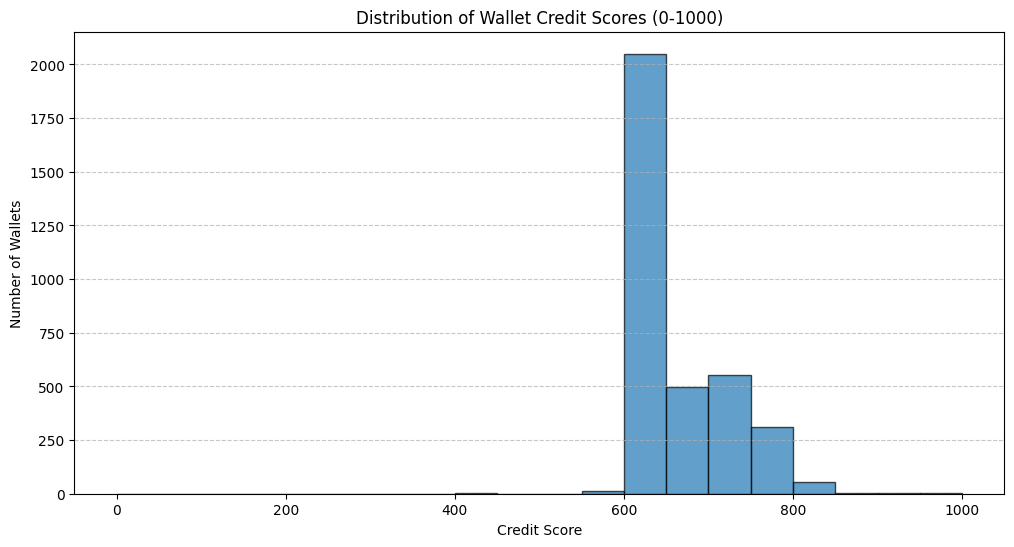

In [7]:
from sklearn.preprocessing import MinMaxScaler

# --- Scoring Model ---
# This is a heuristic model where we assign weights to our engineered features.

print("Starting scoring process...")

# 1. Define Weights for each feature
# Positive features add to the score, negative features subtract from it.
# These weights are chosen based on domain knowledge.
WEIGHTS = {
    # Positive Indicators (Good Behavior)
    'repayment_ratio': 25,      # Most important positive factor
    'lifespan_days': 10,        # Longer activity is better
    'total_deposits_usd': 15,   # Higher value deposited is a good sign
    'transaction_count': 5,     # General activity level
    
    # Negative Indicators (Risky Behavior)
    'liquidation_count': -50    # Most important negative factor
}

# 2. Normalize Features
# We scale all features to a 0-1 range. This is crucial so that features with
# large values (like total_deposits_usd) don't unfairly dominate the score.
scaler = MinMaxScaler()
# We only scale the features that are part of our scoring model
features_to_scale = [col for col in features.columns if col in WEIGHTS]
normalized_features = pd.DataFrame(
    scaler.fit_transform(features[features_to_scale]),
    columns=features_to_scale,
    index=features.index
)

# 3. Calculate Raw Score
# Multiply the normalized features by their weights.
# We initialize the score to zero and then add the weighted feature values.
raw_score = pd.Series(0, index=normalized_features.index, dtype=float)
for feature_name, weight in WEIGHTS.items():
    if feature_name in normalized_features.columns:
        raw_score += normalized_features[feature_name] * weight

# 4. Scale Final Score to 0-1000
# The raw scores are on an arbitrary scale. We use MinMaxScaler again to map
# them to our desired 0-1000 range.
# We need to reshape the raw_score to be a 2D array for the scaler.
final_score_scaler = MinMaxScaler(feature_range=(0, 1000))
final_scores = final_score_scaler.fit_transform(raw_score.values.reshape(-1, 1))

# Add the final score to our main features DataFrame
features['credit_score'] = final_scores.astype(int)


# --- Verification & Visualization ---
print("\n--- Scoring Complete ---")
print("\n--- Sample of Wallets with Final Scores ---")
# Sort by score to see the best and worst wallets
print(features.sort_values('credit_score', ascending=False).head())


print("\n--- Final Score Distribution ---")
plt.figure(figsize=(12, 6))
plt.hist(features['credit_score'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Wallet Credit Scores (0-1000)')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()